In [49]:
import numpy as np
X = np.load("./X_float32.npy")
Y = np.load("./Y_float32.npy")
Y = Y.astype(np.int)

print(X[:10], Y[:10])


[[-1.723399 -0.935617  0.379406 ...  0.421991 -5.475676 -0.757561]
 [ 3.952586 -2.089877 -0.530167 ... -0.665192  3.047655 -0.813977]
 [ 6.717919 -1.515727  2.874858 ... -0.389678  6.818459 -1.956182]
 ...
 [-2.046229 -1.26738  -1.715635 ...  1.583172 -4.322913  0.515094]
 [ 2.208604  1.283815 -4.466554 ... -0.918972 -3.360283  1.760384]
 [-1.05012  -3.193651  0.153887 ... -1.013624 -0.585607 -0.468268]] [-1 -1 -1 -1  1  1  1  1 -1 -1]


max :  43.425953 min :  -45.355846 mean :  0.00013181864 std :  2.9079316
Y.mean :  -0.001948


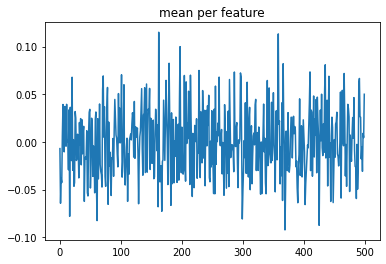

In [50]:
print("max : ", X.max(), "min : ", X.min(), "mean : ", X.mean(), "std : ", np.std(X))
print("Y.mean : ", Y.mean())

import matplotlib.pyplot as plt
plt.plot(np.mean(X,axis=0))
plt.title('mean per feature')
plt.show()


In [14]:
X = X - X.mean(axis=0)
X = X / X.std(axis=0)
Y = (Y+1)/2
Y = Y.astype(np.int)

print(X[:10])

[[-0.43943143 -0.44952556  0.15754016 ...  0.34113452 -0.8996714
  -0.8489112 ]
 [ 1.0138165  -1.0451179  -0.1855545  ... -0.5567451   0.4995988
  -0.90822035]
 [ 1.7218372  -0.7488594   1.0988348  ... -0.32920438  1.1186495
  -2.1089997 ]
 ...
 [-0.522087   -0.6207136  -0.6327179  ...  1.3001274  -0.71042293
   0.48900807]
 [ 0.567297    0.6956903  -1.670376   ... -0.7663362  -0.55238855
   1.798159  ]
 [-0.26704875 -1.6146598   0.07247346 ... -0.8445071  -0.09687167
  -0.5447827 ]]


In [15]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

In [16]:
import tensorflow as tf
size_train = 350000
size_val = 75000
size_test = 75000


X_train = X[:size_train]
Y_train = Y[:size_train]

X_val = X[size_train:size_train+size_val]
Y_val = Y[size_train:size_train+size_val]

X_test = X[size_train+size_val:size_train+size_val+size_test]
Y_test = Y[size_train+size_val:size_train+size_val+size_test]

print("X_train.shape : ", X_train.shape, "Y_train.shape", Y_train.shape)
print("X_val.shape : ", X_val.shape, "Y_train.val", Y_val.shape)
print("X_test.shape : ", X_test.shape, "Y_test.shape", Y_test.shape)


X_train.shape :  (350000, 500) Y_train.shape (350000,)
X_val.shape :  (75000, 500) Y_train.val (75000,)
X_test.shape :  (75000, 500) Y_test.shape (75000,)


In [17]:
import tensorflow as tf

def make_model():
    model = tf.keras.Sequential()
  
    model.add(tf.keras.layers.Dense(2048, input_shape=(500,), kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.65))
    

    
    model.add(tf.keras.layers.Dense(4096, input_shape=(2048,),kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))
    

    

 

    
    model.add(tf.keras.layers.Dense(2, input_shape=(4096,),
                                    kernel_initializer=tf.keras.initializers.GlorotNormal()))
    
    
    
    
    return model

model = make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2048)              1026048   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 4096)             

In [18]:
import time
import os
learning_rate = 0.000025
batch_size = 128
epoch_num = 1000
optimizer = tf.optimizers.Adam(learning_rate = learning_rate)
batch_num = X_train.shape[0]//batch_size
loss_mean = 0
acc_mean = 0
acc_list_train = []
loss_list_train = []
acc_list_val = []
loss_list_val = []
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
Y_train_tensor = tf.data.Dataset.from_tensor_slices(Y_train).batch(batch_size)
X_train_tensor.cache()
Y_train_tensor.cache()
t = time.time()
min_val_acc = 0.879
best_epoch = 0

for epoch in range(epoch_num):
    
    for x,y in zip(X_train_tensor, Y_train_tensor):
        #x = X_train[batch*batch_size:(batch+1)*batch_size]
        #y = Y_train[batch*batch_size:(batch+1)*batch_size]
        
        with tf.GradientTape() as tape:
            logit = model(x, training=True)
            
            cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            loss = cross_entropy(tf.one_hot(y, depth=2), logit)
        grad = tape.gradient(loss, model.trainable_variables)
        
        optimizer.apply_gradients(grads_and_vars=zip(grad, model.trainable_variables))
        loss_mean += loss.numpy()
        acc = tf.equal(tf.argmax(logit, axis=1), y).numpy()
        
        acc = acc.mean()
        acc_mean += acc

        
    loss_mean/=batch_num
    acc_mean/=batch_num
    print("Epoch : ", epoch, "loss : ", loss_mean, "accuracy", acc_mean)
    
    
    loss_list_train.append(loss_mean)
    acc_list_train.append(acc_mean)
    
    mask = np.random.choice(range(X_val.shape[0]), 40960, replace=False)
    x = X_val[mask]
    y = Y_val[mask]
    output = model(x, training=False)
    loss = cross_entropy(tf.one_hot(y, depth=2), output)
    acc_val = tf.equal(tf.argmax(output,axis=1), y.astype(np.int)).numpy().mean()
    
    if acc_val>min_val_acc:
        min_val_acc = acc_val
        best_epoch = epoch
        checkpoint_dir = './ckpt_final3_'+ str(acc_val*1000)[:3] + "_" + str(epoch)
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        root.save(checkpoint_prefix)
        print("---------------------saved--------------------", time.time()-t)
    loss_list_val.append(loss)
    acc_list_val.append(acc_val)
    
    print("Validation   ", "loss : ", loss.numpy(), "accuracy : ", acc_val)
    #if acc_val>0.88:
      #  break
print("Train time : " , time.time() - t)   


Epoch :  0 loss :  0.6861876953494052 accuracy 0.6498110217020239
Validation    loss :  0.477256 accuracy :  0.7756103515625
Epoch :  1 loss :  0.5731105531095111 accuracy 0.7282337077011833
Validation    loss :  0.43774885 accuracy :  0.798291015625
Epoch :  2 loss :  0.5232000519593919 accuracy 0.7554642177058162
Validation    loss :  0.41777354 accuracy :  0.811865234375
Epoch :  3 loss :  0.4905185653632922 accuracy 0.7722707669047936
Validation    loss :  0.40394706 accuracy :  0.8183837890625
Epoch :  4 loss :  0.46651884231987517 accuracy 0.7847414807121085
Validation    loss :  0.39639965 accuracy :  0.82080078125
Epoch :  5 loss :  0.4489172098488743 accuracy 0.7933034061134037
Validation    loss :  0.38749972 accuracy :  0.8264892578125
Epoch :  6 loss :  0.4357612262197662 accuracy 0.7999407809337161
Validation    loss :  0.38102415 accuracy :  0.82939453125
Epoch :  7 loss :  0.42446022931939753 accuracy 0.8057087612585713
Validation    loss :  0.37726313 accuracy :  0.8310

KeyboardInterrupt: 

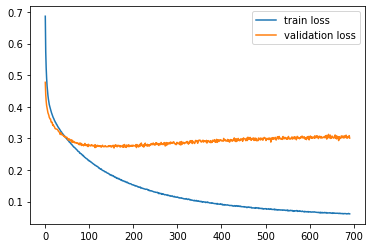

In [19]:
import matplotlib.pyplot as plt
plt.plot(loss_list_train, label='train loss')
plt.plot(loss_list_val, label='validation loss')
plt.legend()
plt.show()


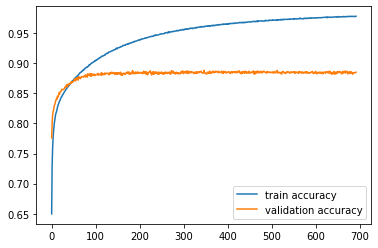

In [20]:
plt.plot(acc_list_train, label='train accuracy')
plt.plot(acc_list_val, label='validation accuracy')
plt.legend()
plt.show()

In [21]:
print("max validation accuracy : ", max(acc_list_val))
print("index of max : ", acc_list_val.index(max(acc_list_val)))

max validation accuracy :  0.887841796875
index of max :  512


In [23]:
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)
root.restore(tf.train.latest_checkpoint('./ckpt_final3_887_512'))

In [51]:
test_batchNum = X_test.shape[0]//75000

loss_test_mean = 0
acc_test_mean = 0
for batch in range(test_batchNum):
    mask = np.random.choice(range(X_test.shape[0]), 75000, replace=False)
    x = X_test[mask]
    y = Y_test[mask]
    output = model(x, training=False)
    
    loss_test = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.one_hot(y, depth=2), output)
    acc_test = tf.equal(tf.argmax(output,axis=1), y.astype(np.int)).numpy().mean()
    
    loss_test_mean += loss_test.numpy()/test_batchNum
    acc_test_mean += acc_test/test_batchNum
   
print("Test   ", "loss : ", loss_test_mean, "accuracy : ", acc_test_mean, "error : ", 1-acc_test_mean)

Test    loss :  0.2960577607154846 accuracy :  0.88548 error :  0.11451999999999996


In [45]:
mask_F = (tf.argmax(output, axis=1).numpy() != y)
mask_T = (tf.argmax(output, axis=1).numpy() == y)

output_F = tf.argmax(output[mask_F], axis=1).numpy()
output_T = tf.argmax(output[mask_T], axis=1).numpy()

print(len(output_T), " | TP : ", np.sum(output_T), " TN : ", len(output_T)-np.sum(output_T))
print(len(output_F), "  | FP : ", np.sum(output_F), "  FN : ", len(output_F)-np.sum(output_F))

66411  | TP :  32934  TN :  33477
8589   | FP :  4158   FN :  4431
